# A/B Compartment Calling Benchmark

This notebook contains the code to reproduce Figure 4 and S14-S17.

Required data are:

1. Su et al, 2020, Cell: chromosome 2 p-arm and whole chromosome

    Download the first four tsv from https://zenodo.org/records/3928890
    
    Uncomment `proc_su_cell_2020(args.datadir)` and run in terminal

    This outputs ../data/su_cell_2020/chromosome2_p-arm_replicate.csv and ../data/su_cell_2020/chromosome2.csv

2. ChIP-seq data of human IMR-90

    data.json: chipseq_imr90

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import anndata as ad

from utils import out_dire
from utils.data import DataTree
import arcfish as af
dtree = DataTree("../data")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
su = "../data/su_cell_2020"

## Chromosome 2 p-arm full data

In [4]:
loader = af.pp.FOF_CT_Loader(f"{su}/chromosome2_p-arm_replicate.csv")

In [5]:
p1 = os.path.join(out_dire, "chromosome2_p-arm_replicate.h5ad")
if not os.path.exists(p1):
    adata = loader.create_adata("chr2")
    af.tl.median_pdist(adata, inplace=True)
    af.pp.filter_normalize(adata)
    adata.write_h5ad(p1, compression="gzip")
else:
    adata = ad.read_h5ad(p1)
med_dist = adata.varp["med_dist"]

In [6]:
adata

AnnData object with n_obs × n_vars = 4848 × 357
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'count_X', 'count_Y', 'count_Z', 'med_dist', 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'var_X', 'var_Y', 'var_Z'

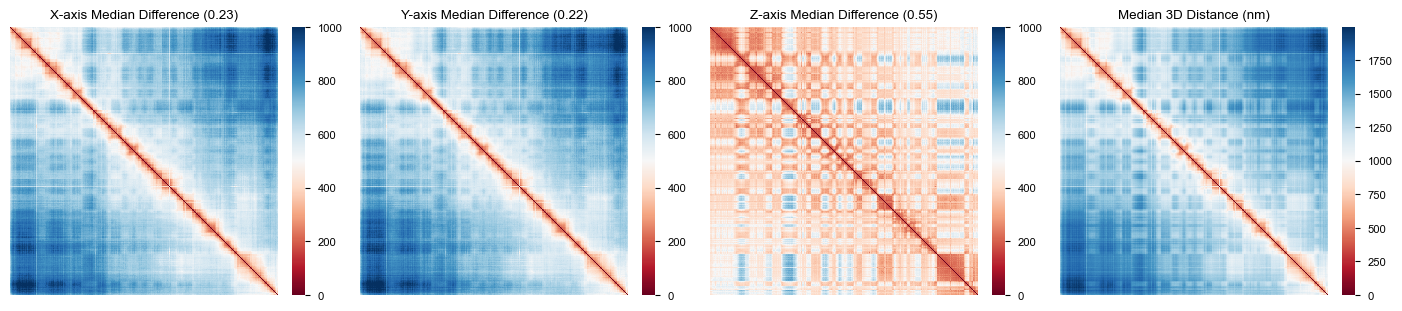

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
wts = af.pp.axis_weight(adata, inplace=False)
for i, (c, w) in enumerate(zip(["X", "Y", "Z"], wts)):
    mat = adata.varp[f"raw_var_{c}"]**.5
    af.pl.pairwise_heatmap(mat, ax=axes[i], vmax=1000, rasterized=True)
    axes[i].set_title(f"{c}-axis Median Difference ({w:.2f})")
af.pl.pairwise_heatmap(med_dist, ax=axes[3], rasterized=True)
axes[3].set_title("Median 3D Distance (nm)")
fig.savefig(os.path.join(out_dire, "su_parm_pdist.pdf"), bbox_inches="tight")

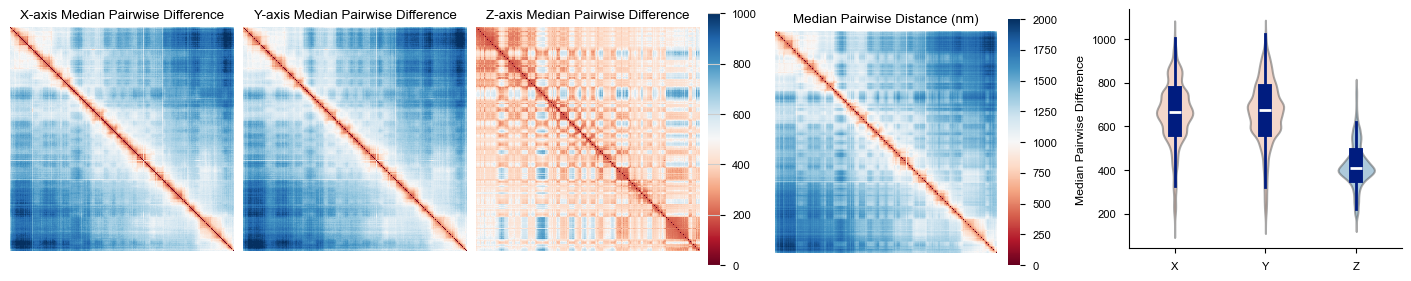

In [15]:
fig = plt.figure(figsize=(14, 2.7))
figs = fig.subfigures(1, 3, width_ratios=[9.05, 3.5, 4])
axes = figs[0].subplots(1, 4, width_ratios=[1, 1, 1, 0.05])
pdiff = np.stack([adata.varp[f"pdiff_{c}"] for c in ["X", "Y", "Z"]])
for i, (c, ax) in enumerate(zip(["X", "Y", "Z"], axes[:3])):
    af.pl.pairwise_heatmap(pdiff[i], cbar_ax=axes[-1], vmin=0, vmax=1000, rasterized=True, ax=ax)
    ax.set(title=f"{c}-axis Median Pairwise Difference")
ax = figs[1].subplots()
af.pl.pairwise_heatmap(adata.varp["med_dist"], vmin=0, vmax=2000, rasterized=True,
                       title="Median Pairwise Distance (nm)", ax=ax)

uidx = np.triu_indices_from(pdiff[0], 1)
plt_df = (
    pd.DataFrame(pdiff[:,*uidx], index=["X", "Y", "Z"]).T
    .melt(var_name="axis", value_name="diff")
)
ax = figs[2].subplots()
c1, c2 = plt.colormaps["RdBu"](80), plt.colormaps["RdBu"](200)
sns.violinplot(
    plt_df, x="axis", y="diff", hue="axis", width=0.4, 
    fill=True, alpha=0.5,
    palette={"X": c1, "Y": c1, "Z": c2}, linewidth=1.5, ax=ax,
    inner_kws=dict(box_width=10, whis_width=2, color=sns.color_palette("dark")[0])
)
ax.grid(False)
ax.set(xlabel="", ylabel="Median Pairwise Difference")
fig.savefig(os.path.join(out_dire, "su_parm_pairwise_diff.pdf"), bbox_inches="tight")

In [8]:
caller = af.tl.ABCaller(0, "hg38", cutoff=500, sigma=1.9, method="pca")
res_sf1 = caller.call_cpmt(adata)
caller = af.tl.ABCaller(0, "hg38", method="axes")
res_sf2 = caller.call_cpmt(adata)

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/tools/cpmt.py:194: UserWarning: Centromere position not found in the imaging region. Calling A/B compartments for the whole chromosome.
  warnings.warn(
/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/tools/cpmt.py:194: UserWarning: Centromere position not found in the imaging region. Calling A/B compartments for the whole chromosome.
  warnings.warn(


In [9]:
import pyBigWig
# Already 250Kb binned, same as su et al
with pyBigWig.open(dtree["rao_cell_2014","imr90","compartments"]) as bw:
    cpmt_vals = []
    for _, row in adata.var.iterrows():
        v = bw.values(adata.uns["Chrom"], row.Chrom_Start, row.Chrom_End)
        v = stats.mode(np.array(v)[~np.isnan(v)])[0]
        cpmt_vals.append([row.Chrom_Start, row.Chrom_End, v])
    cpmt_vals = pd.DataFrame(cpmt_vals, columns=["s1", "e1", "val"])
    cpmt_vals["c1"] = adata.uns["Chrom"]
cpmt_vals = cpmt_vals[["c1", "s1", "e1", "val"]]
cpmt_vals["cpmt"] = (cpmt_vals.val <= 0).astype(int)
len(cpmt_vals)

357

In [10]:
bed_paths = [
    os.path.join(out_dire, "chr2_p-arm_sf1.bed"),
    os.path.join(out_dire, "chr2_p-arm_sf2.bed"),
]
for p, df in zip(bed_paths, [res_sf1, res_sf2]):
    df = df.copy()
    df.iloc[:-1,2] = df["s1"].iloc[1:]
    df[df.cpmt==0].iloc[:,:3].to_csv(
        p, index=False, sep="\t", header=False
    )

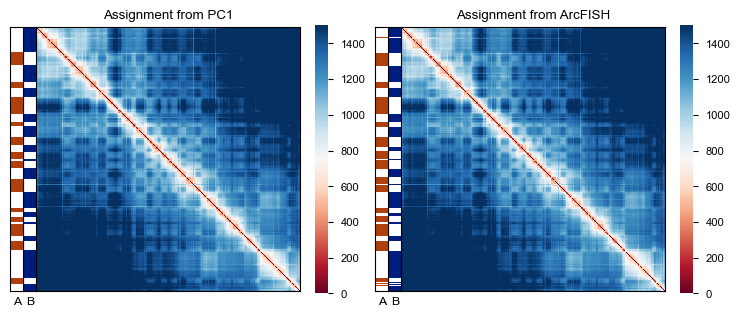

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(7.3, 3))
af.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("Assignment from PC1")
af.pl.cpmt_bars(res_sf1.cpmt.values, ax=axes[0])
af.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[1])
axes[1].set_title("Assignment from ArcFISH")
af.pl.cpmt_bars(res_sf2.cpmt.values, ax=axes[1])
fig.savefig(os.path.join(out_dire, "su_parm_pdist_assign.pdf"), bbox_inches="tight")

In [12]:
cpmt1, cpmt2 = res_sf1.cpmt.values, res_sf2.cpmt.values
np.sum((cpmt1 - cpmt2) != 0), np.sum((cpmt1 - cpmt2) != 0)/len(cpmt1)

(27, 0.07563025210084033)

In [13]:
hic_cpmt = (cpmt_vals.val <= 0).astype(int)
np.sum((cpmt1 - hic_cpmt) != 0), np.sum((hic_cpmt - cpmt2) != 0)

(56, 57)

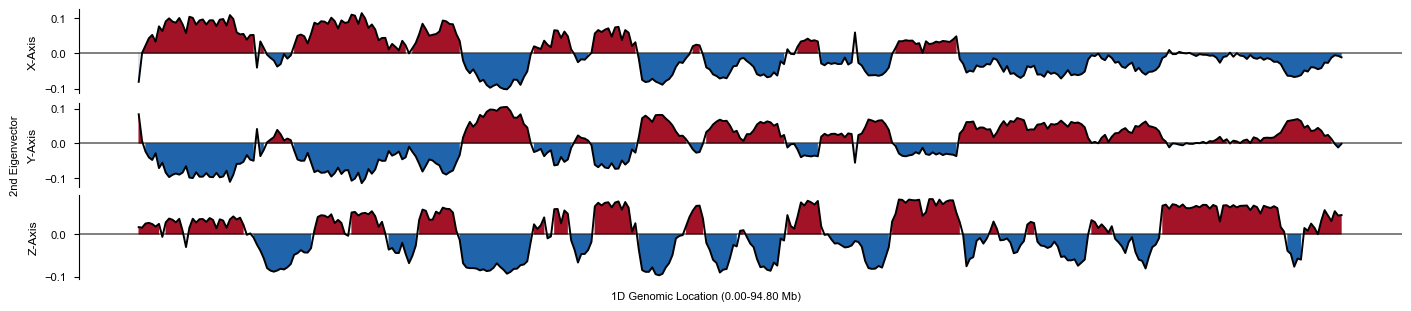

In [14]:
df = res_sf2
fig, axes = plt.subplots(3, 1, figsize=(14, 3), sharex=True)
for i, c in enumerate(["x", "y", "z"]):
    af.pl.cpmt_vals(df[f"eig_{c}"].values, ax=axes[i])
    axes[i].set_ylabel(f"{c.upper()}-Axis")
dmin, dmax = df["s1"].min()/1e6, df["e1"].max()/1e6
fig.supxlabel(f"1D Genomic Location ({dmin:.2f}-{dmax:.2f} Mb)", fontsize=8)
fig.supylabel("2nd Eigenvector", fontsize=8)
out_name = os.path.join(out_dire, "chr2_parm_eig.pdf")
fig.savefig(out_name, bbox_inches="tight")

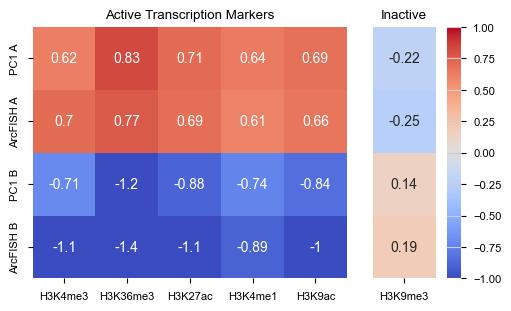

In [15]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata, res_sf1, res_sf2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="PC1", name2="ArcFISH"
)
out_name = os.path.join(out_dire, "chr2_parm_full_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [16]:
for mk in ["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac", "H3K9me3"]:
    print(dtree["chipseq_imr90", mk, "bigWig"])

../data/chipseq_imr90/ENCFF518GFI.bigWig
../data/chipseq_imr90/ENCFF314QXF.bigWig
../data/chipseq_imr90/ENCFF222IQN.bigWig
../data/chipseq_imr90/ENCFF148PNW.bigWig
../data/chipseq_imr90/ENCFF682HNO.bigWig
../data/chipseq_imr90/ENCFF733CJA.bigWig


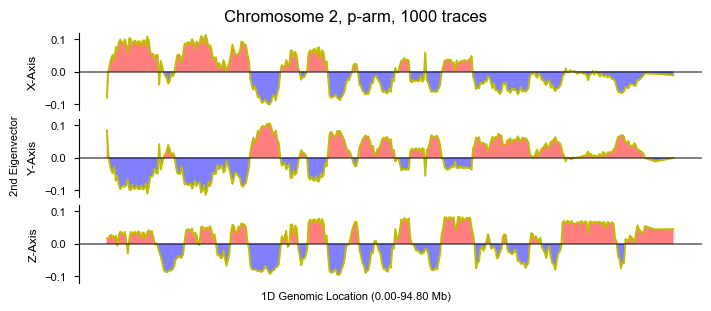

In [20]:
df = res_sf2
fig, axes = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
for i, c in enumerate(["x", "y", "z"]):
    sns.lineplot(df, x="s1", y=f"eig_{c}", color="y", ax=axes[i])
    axes[i].spines['bottom'].set_visible(False)
    xmin, xmax = axes[i].get_xlim()
    axes[i].hlines([0], xmin=xmin, xmax=xmax, color="k", alpha=0.5)
    axes[i].set(xlim=(xmin, xmax), ylim=(-0.12, 0.12), xticks=[])
    axes[i].set(ylabel=f"{c}-Axis".title())
    axes[i].fill_between(
        df["s1"], df[f"eig_{c}"], 0, where=df[f"eig_{c}"]>=0, 
        alpha=0.5, color="r"
    )
    axes[i].fill_between(
        df["s1"], df[f"eig_{c}"], 0, where=df[f"eig_{c}"]<=0, 
        alpha=0.5, color="b"
    )
    axes[i].grid(False)
dmin, dmax = df["s1"].min()/1e6, df["e1"].max()/1e6
fig.supxlabel(f"1D Genomic Location ({dmin:.2f}-{dmax:.2f} Mb)", fontsize=8)
fig.supylabel("2nd Eigenvector", fontsize=8)
fig.suptitle("Chromosome 2, p-arm, 1000 traces")
out_name = os.path.join(out_dire, "chr2_parm_1ktr_eig.pdf")
fig.savefig(out_name, bbox_inches="tight")

## Varying number of traces

In [19]:
pca_df = []
for i in range(10):
    f = os.path.join(out_dire, f"cpmt_pca_replicate_{i}.csv")
    pca_df.append(pd.read_csv(f))
pca_df = pd.concat(pca_df).pivot(
    index="s1", columns=["num_cells", "replicate"], values="cpmt"
)

sf2_df = []
for i in range(10):
    f = os.path.join(out_dire, f"cpmt_replicate_{i}.csv")
    sf2_df.append(pd.read_csv(f))
sf2_df = pd.concat(sf2_df).pivot(
    index="s1", columns=["num_cells", "replicate"], values="cpmt"
)

In [20]:
d1df = adata.var.reset_index(drop=True)
d1df["Chrom"] = adata.uns["Chrom"]
d1df = d1df[["Chrom", "Chrom_Start", "Chrom_End"]]
enrich_df_byn = []
for marker in dtree["chipseq_imr90"]:
    chip_df = pd.read_csv(
        dtree["chipseq_imr90",marker,"peak"], sep="\t", 
        header=None, usecols=[0, 1, 2]
    )
    chip_df.columns = ["c1", "s1", "e1"]
    
    out_ls = []
    for chr_id in pd.unique(d1df.Chrom):
        sub_df = d1df[d1df["Chrom"]==chr_id].copy()
        ints1 = sub_df.iloc[:,1:].values
        ints2 = chip_df[chip_df["c1"]==chr_id][["s1","e1"]].values
        out_ls.append(sub_df[af.tl.overlap(ints1, ints2)])
    chipseq_marked = pd.concat(out_ls, ignore_index=True).rename({
        "Chrom":"c1", "Chrom_Start":"s1", "Chrom_End":"e1"
    }, axis=1)["s1"].values

    for met, df in zip(["PC1", "ArcFISH"], [pca_df, sf2_df]):
        marked_count = df.loc[chipseq_marked].sum(axis=0).to_frame("TP_B")
        m, p = len(chipseq_marked), df.shape[0]
        a, b = p - df.sum(axis=0), df.sum(axis=0)
        marked_count["A"] = np.log2(((m - marked_count.TP_B) / a) / (m/p))
        marked_count["B"] = np.log2((marked_count.TP_B / b) / (m/p))
        marked_count = marked_count[["A", "B"]].reset_index().melt(
            id_vars=["num_cells", "replicate"], var_name="cpmt", value_name="fold"
        )
        marked_count["method"] = met
        marked_count["marker"] = marker
        enrich_df_byn.append(marked_count)
enrich_df_byn = pd.concat(enrich_df_byn, ignore_index=True)

In [21]:
hic_df = cpmt_vals.set_index("s1")[["cpmt"]]
hic_enrich = []
for marker in dtree["chipseq_imr90"]:
    chip_df = pd.read_csv(
        dtree["chipseq_imr90",marker,"peak"], sep="\t", 
        header=None, usecols=[0, 1, 2]
    )
    chip_df.columns = ["c1", "s1", "e1"]
    
    out_ls = []
    for chr_id in pd.unique(d1df.Chrom):
        sub_df = d1df[d1df["Chrom"]==chr_id].copy()
        ints1 = sub_df.iloc[:,1:].values
        ints2 = chip_df[chip_df["c1"]==chr_id][["s1","e1"]].values
        out_ls.append(sub_df[af.tl.overlap(ints1, ints2)])
    chipseq_marked = pd.concat(out_ls, ignore_index=True).rename({
        "Chrom":"c1", "Chrom_Start":"s1", "Chrom_End":"e1"
    }, axis=1)["s1"].values
    
    df = hic_df
    marked_count = df.loc[chipseq_marked].sum(axis=0).to_frame("TP_B")
    m, p = len(chipseq_marked), df.shape[0]
    a, b = p - df.sum(axis=0), df.sum(axis=0)
    marked_count["A"] = np.log2(((m - marked_count.TP_B) / a) / (m/p))
    marked_count["B"] = np.log2((marked_count.TP_B / b) / (m/p))
    marked_count = marked_count[["A", "B"]]
    marked_count["marker"] = marker
    hic_enrich.append(marked_count)
hic_enrich = pd.concat(hic_enrich, ignore_index=True)
hic_enrich.set_index("marker", inplace=True)

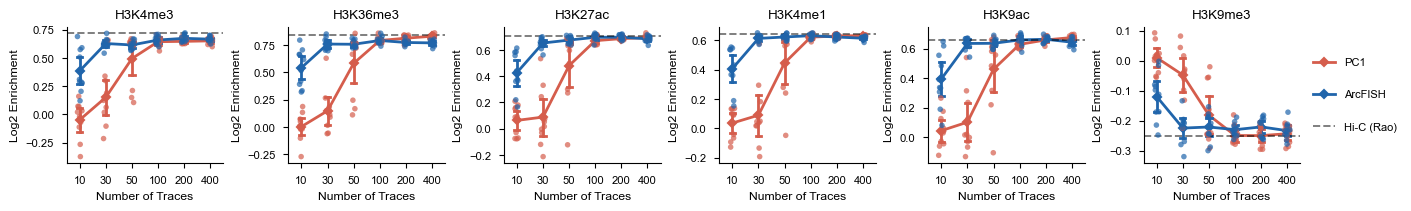

In [23]:
fig, axes = plt.subplots(1, 7, figsize=(14, 2), width_ratios=[1]*6+[0.2])
markers = ["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac", "H3K9me3"]
c1, c2 = plt.colormaps.get_cmap("RdBu")(50), plt.colormaps.get_cmap("RdBu")(230)
colors = {"PC1": c1, "ArcFISH": c2}
for i, marker in enumerate(markers):
    plt_df = enrich_df_byn[enrich_df_byn.marker == marker].copy()
    plt_df["x"] = "abc" + plt_df["num_cells"].astype(str)
    plt_df = plt_df[plt_df.cpmt == "A"]
    sns.pointplot(plt_df, x="x", y="fold", hue="method", errorbar=("se", 2), linewidth=2,
                  capsize=.2, markersize=4, marker="D", palette=colors, ax=axes[i])
    axes[i].axhline(hic_enrich.loc[marker,"A"], color="k", alpha=0.5, linestyle="--", label="Hi-C (Rao)")
    sns.stripplot(plt_df, x="x", y="fold", hue="method", 
                  palette=colors, alpha=.7, s=4, ax=axes[i])
    axes[i].set(title=marker, xlabel="Number of Traces", ylabel="Log2 Enrichment")
    xticklabels = [t.get_text()[3:] for t in axes[i].get_xticklabels()]
    axes[i].set(xticks=axes[i].get_xticks(), xticklabels=xticklabels)
    axes[i].grid(False)
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
axes[6].legend(handles[:3], labels[:3], loc="center", labelspacing=2, bbox_to_anchor=(0.5, 0.5))
axes[6].axis("off")
fig.savefig(os.path.join(out_dire, "chr2_parm_enrich_point.pdf"), bbox_inches="tight")

In [25]:
for marker in markers:
    plt_df = enrich_df_byn[enrich_df_byn.marker == marker].copy()
    sub_df = plt_df[(plt_df["num_cells"]==30)&(plt_df.cpmt == "A")]
    x = sub_df[sub_df["method"]=="PC1"].fold.values
    y = sub_df[sub_df["method"]=="ArcFISH"].fold.values
    print(f"mean1: {x.mean():.4f}, mean2: {y.mean():.4f}", end=", ")
    print(f"P-value={stats.mannwhitneyu(x, y)[1]:.4f}")

mean1: 0.1517, mean2: 0.6285, P-value=0.0017
mean1: 0.1470, mean2: 0.7571, P-value=0.0002
mean1: 0.0880, mean2: 0.6527, P-value=0.0002
mean1: 0.0889, mean2: 0.6127, P-value=0.0002
mean1: 0.1026, mean2: 0.6350, P-value=0.0002
mean1: -0.0476, mean2: -0.2248, P-value=0.0013


In [26]:
hic_enrich

,A,B
marker,,
CTCF,0.524054,-0.825065
POLR2A,0.749474,-1.632067
SMC3,0.623225,-1.111839
H3K4me3,0.722634,-1.500461
H3K27ac,0.707329,-1.431457
H3K27me3,0.318155,-0.406134
H3K4me1,0.643547,-1.181229
H3K36me3,0.841108,-2.231104
H3K9me3,-0.251454,0.212952


## Fewer traces and whole chromosome

In [27]:
adata3 = loader.create_adata("chr2")[:30]
med_dist3 = af.tl.median_pdist(adata3, inplace=False)
af.pp.filter_normalize(adata3)

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:34: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = raw_var[i]


In [28]:
caller = af.tl.ABCaller(0, "hg38", False, cutoff=500, sigma=1.9, method="pca")
res_sf1_sub = caller.call_cpmt(adata3)
caller = af.tl.ABCaller(0, "hg38", False, method="axes")
res_sf2_sub = caller.call_cpmt(adata3)

In [29]:
bed_paths = [
    os.path.join(out_dire, "chr2_p-arm_replicate_hic.bed"),
    os.path.join(out_dire, "chr2_p-arm_replicate_sf1.bed"),
    os.path.join(out_dire, "chr2_p-arm_replicate_sf2.bed"),
]
for p, df in zip(bed_paths, [cpmt_vals, res_sf1_sub, res_sf2_sub]):
    df = df.copy()
    df.iloc[:-1,2] = df["s1"].iloc[1:]
    df[df.cpmt==0].iloc[:,:3].to_csv(
        p, index=False, sep="\t", header=False
    )

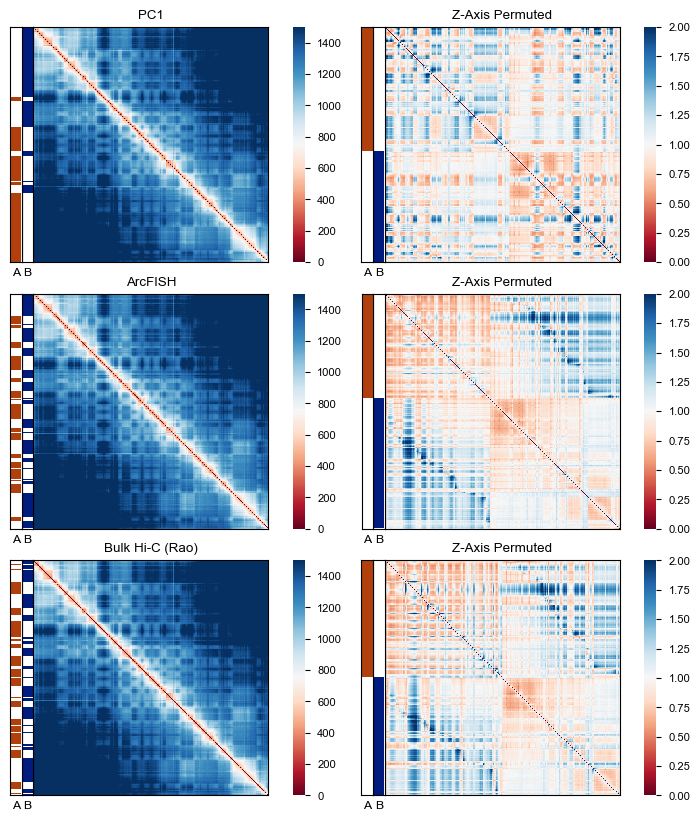

In [30]:
from utils.maps import permute_cpmt_heatmap
fig, axes = plt.subplots(3, 2, figsize=(7, 8))
axes = axes.flatten()

af.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("PC1")
af.pl.cpmt_bars(res_sf1_sub.cpmt.values, ax=axes[0])
permute_cpmt_heatmap(res_sf1_sub.cpmt.values, adata, axes[1])

af.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[2])
axes[2].set_title("ArcFISH")
af.pl.cpmt_bars(res_sf2_sub.cpmt.values, ax=axes[2])
permute_cpmt_heatmap(res_sf2_sub.cpmt.values, adata, axes[3])

af.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[4])
axes[4].set_title("Bulk Hi-C (Rao)")
af.pl.cpmt_bars(cpmt_vals.cpmt.values, ax=axes[4])
permute_cpmt_heatmap(cpmt_vals.cpmt.values, adata, axes[5])

fig.savefig(os.path.join(out_dire, "su_parm_sub_assign.pdf"), bbox_inches="tight")

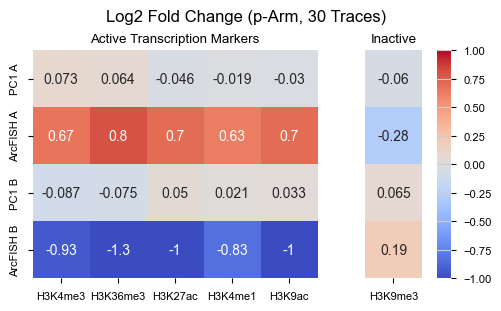

In [31]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata, res_sf1_sub, res_sf2_sub, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="PC1", name2="ArcFISH"
)
fig.suptitle("Log2 Fold Change (p-Arm, 30 Traces)")
out_name = os.path.join(out_dire, "chr2_parm_30tr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [39]:
loader2 = af.pp.FOF_CT_Loader(f"{su}/chromosome2.csv")
p2 = os.path.join(out_dire, "chromosome2.h5ad")
if not os.path.exists(p2):
    adata2 = loader2.create_adata("chr2")
    af.tl.median_pdist(adata2, inplace=True)
    af.pp.filter_normalize(adata2)
    adata2.write_h5ad(p2, compression="gzip")
else:
    adata2 = ad.read_h5ad(p2)
med_dist2 = adata2.varp["med_dist"]

In [40]:
adata2

AnnData object with n_obs × n_vars = 3029 × 935
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'count_X', 'count_Y', 'count_Z', 'med_dist', 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'var_X', 'var_Y', 'var_Z'

In [34]:
import pyBigWig
# Already 250Kb binned, same as su et al
with pyBigWig.open(dtree["rao_cell_2014","imr90","compartments"]) as bw:
    cpmt_vals_2 = []
    for _, row in adata2.var.iterrows():
        v = bw.values(adata2.uns["Chrom"], row.Chrom_Start, row.Chrom_End)
        v = stats.mode(np.array(v)[~np.isnan(v)])[0]
        cpmt_vals_2.append([row.Chrom_Start, row.Chrom_End, v])
    cpmt_vals_2 = pd.DataFrame(cpmt_vals_2, columns=["s1", "e1", "val"])
cpmt_vals_2["cpmt"] = (cpmt_vals_2.val <= 0).astype(int)
len(cpmt_vals_2)

935

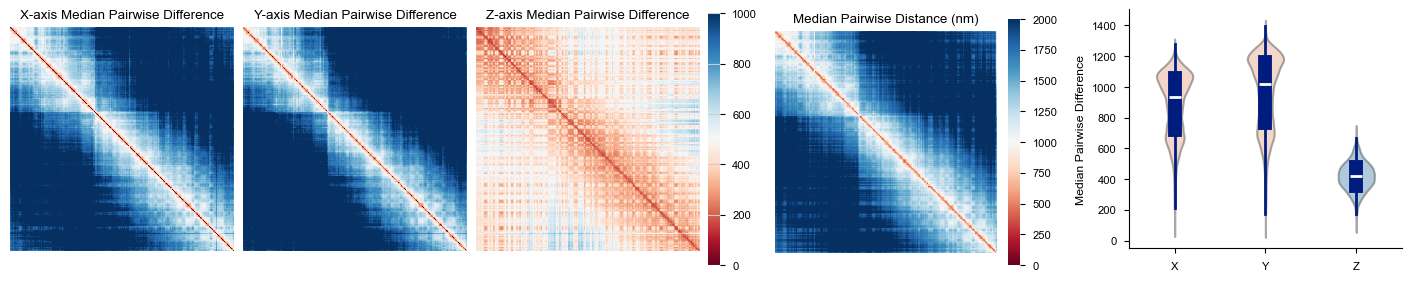

In [36]:
fig = plt.figure(figsize=(14, 2.7))
figs = fig.subfigures(1, 3, width_ratios=[9.05, 3.5, 4])
axes = figs[0].subplots(1, 4, width_ratios=[1, 1, 1, 0.05])
pdiff = np.stack([adata2.varp[f"pdiff_{c}"] for c in ["X", "Y", "Z"]])
for i, (c, ax) in enumerate(zip(["X", "Y", "Z"], axes[:3])):
    af.pl.pairwise_heatmap(pdiff[i], cbar_ax=axes[-1], vmin=0, vmax=1000, rasterized=True, ax=ax)
    ax.set(title=f"{c}-axis Median Pairwise Difference")
ax = figs[1].subplots()
af.pl.pairwise_heatmap(adata2.varp["med_dist"], vmin=0, vmax=2000, rasterized=True,
                       title="Median Pairwise Distance (nm)", ax=ax)

uidx = np.triu_indices_from(pdiff[0], 1)
plt_df = (
    pd.DataFrame(pdiff[:,*uidx], index=["X", "Y", "Z"]).T
    .melt(var_name="axis", value_name="diff")
)
ax = figs[2].subplots()
c1, c2 = plt.colormaps["RdBu"](80), plt.colormaps["RdBu"](200)
sns.violinplot(
    plt_df, x="axis", y="diff", hue="axis", width=0.4, 
    fill=True, alpha=0.5,
    palette={"X": c1, "Y": c1, "Z": c2}, linewidth=1.5, ax=ax,
    inner_kws=dict(box_width=10, whis_width=2, color=sns.color_palette("dark")[0])
)
ax.grid(False)
ax.set(xlabel="", ylabel="Median Pairwise Difference")
fig.savefig(os.path.join(out_dire, "su_chr2_pairwise_diff.pdf"), bbox_inches="tight")

In [41]:
caller = af.tl.ABCaller(0, "hg38", False, cutoff=500, sigma=1.9, method="pca")
res_sf1_chr2 = caller.call_cpmt(adata2)
caller = af.tl.ABCaller(0, "hg38", False, method="axes")
res_sf2_chr2 = caller.call_cpmt(adata2)

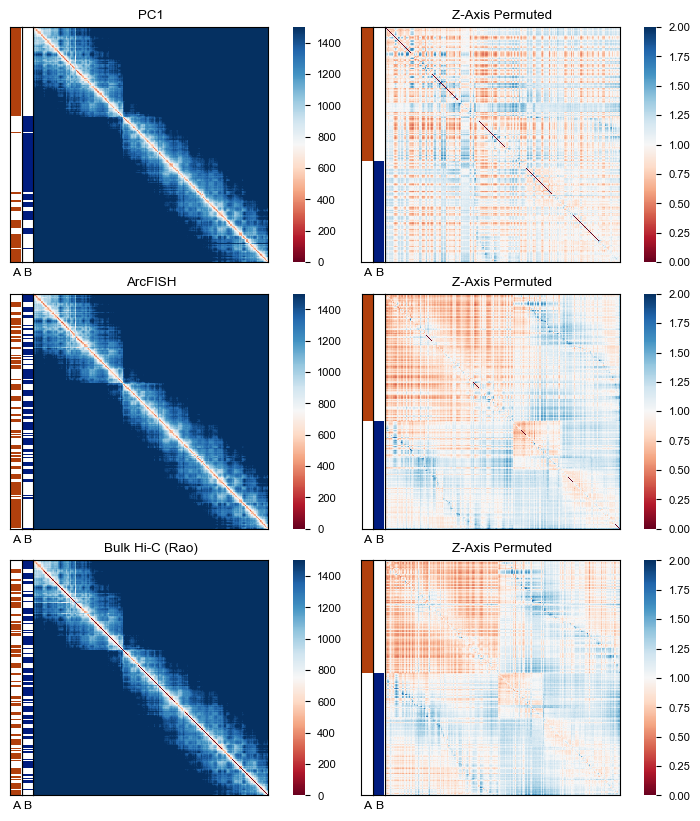

In [42]:
from utils.maps import permute_cpmt_heatmap
fig, axes = plt.subplots(3, 2, figsize=(7, 8))
axes = axes.flatten()

af.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("PC1")
af.pl.cpmt_bars(res_sf1_chr2.cpmt.values, ax=axes[0])
permute_cpmt_heatmap(res_sf1_chr2.cpmt.values, adata2, axes[1])

af.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[2])
axes[2].set_title("ArcFISH")
af.pl.cpmt_bars(res_sf2_chr2.cpmt.values, ax=axes[2])
permute_cpmt_heatmap(res_sf2_chr2.cpmt.values, adata2, axes[3])

af.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[4])
axes[4].set_title("Bulk Hi-C (Rao)")
af.pl.cpmt_bars(cpmt_vals_2.cpmt.values, ax=axes[4])
permute_cpmt_heatmap(cpmt_vals_2.cpmt.values, adata2, axes[5])

fig.savefig(os.path.join(out_dire, "su_chr2_assign.pdf"), bbox_inches="tight")

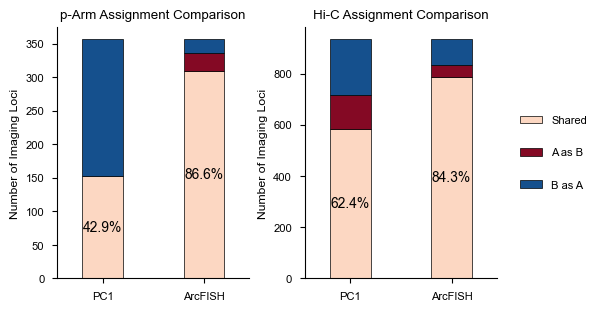

In [43]:
shared_color = plt.colormaps["RdBu"](100)
raw_spe_color = plt.colormaps["RdBu"](10)
noi_spe_color = plt.colormaps["RdBu"](240)
color=[shared_color, raw_spe_color, noi_spe_color]

fig, axes = plt.subplots(1, 3, figsize=(6, 3), width_ratios=[1, 1, .5])
diff = res_sf1.cpmt.values - res_sf1_chr2.cpmt.values[:len(res_sf1)]
plt_df1 = pd.Series({"Shared": np.nansum(diff==0), "A as B": np.nansum(diff==-1), 
                     "B as A": np.nansum(diff==1)}).to_frame("PC1")
diff = res_sf2.cpmt.values - res_sf2_chr2.cpmt.values[:len(res_sf2)]
plt_df2 = pd.Series({"Shared": np.nansum(diff==0), "A as B": np.nansum(diff==-1), 
                     "B as A": np.nansum(diff==1)}).to_frame("ArcFISH")
plt_df = pd.concat([plt_df1, plt_df2], axis=1)
plt_df.T.plot(kind="bar", stacked=True, linewidth=.5, edgecolor="k",
            color=color, width=0.4, ax=axes[0])
handles, labels = axes[0].get_legend_handles_labels()
axes[0].set(title="p-Arm Assignment Comparison")

diff = cpmt_vals_2.cpmt.values - res_sf1_chr2.cpmt.values[:len(cpmt_vals_2)]
plt_df1 = pd.Series({"Shared": np.nansum(diff==0), "A as B": np.nansum(diff==-1), 
                     "B as A": np.nansum(diff==1)}).to_frame("PC1")
diff = cpmt_vals_2.cpmt.values - res_sf2_chr2.cpmt.values[:len(cpmt_vals_2)]
plt_df2 = pd.Series({"Shared": np.nansum(diff==0), "A as B": np.nansum(diff==-1), 
                     "B as A": np.nansum(diff==1)}).to_frame("ArcFISH")
plt_df = pd.concat([plt_df1, plt_df2], axis=1)
plt_df.T.plot(kind="bar", stacked=True, linewidth=.5, edgecolor="k",
            color=color, width=0.4, ax=axes[1])
handles, labels = axes[0].get_legend_handles_labels()
axes[1].set(title="Hi-C Assignment Comparison")

for i in range(2):
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
    axes[i].set(ylabel="Number of Imaging Loci")
    axes[i].get_legend().remove()
    axes[i].grid(False)
    
    bar = axes[1].patches[i]
    axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
                f"{bar.get_height()/len(cpmt_vals_2)*100:.1f}%", ha="center", verticalalignment="center")
    bar = axes[0].patches[i]
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
                f"{bar.get_height()/len(res_sf1)*100:.1f}%", ha="center", verticalalignment="center")


axes[2].legend(handles[:3], labels[:3], loc="center", labelspacing=2, bbox_to_anchor=(0.5, 0.5))
axes[2].axis("off")
fig.savefig(os.path.join(out_dire, "su_chr2_assign_comp.pdf"), bbox_inches="tight")

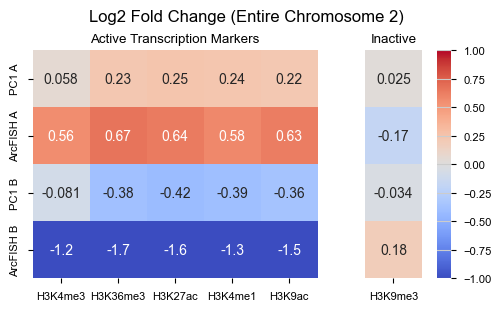

In [44]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata2, res_sf1_chr2, res_sf2_chr2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="PC1", name2="ArcFISH"
)
fig.suptitle("Log2 Fold Change (Entire Chromosome 2)")
out_name = os.path.join(out_dire, "chr2_3ktr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

## Weighted versus unweighted eigenvectors

In [45]:
df1 = res_sf2_chr2.copy()
df1["cpmt"] = KMeans(2, random_state=0).fit_predict(df1[["eig_x", "eig_y", "eig_z"]])
df2 = res_sf2_chr2.copy()
df2["cpmt"] = 1 - KMeans(2, random_state=0).fit_predict(df2[["wteig_x", "wteig_y", "wteig_z"]])

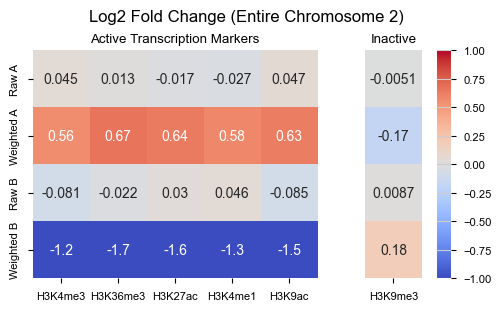

In [48]:
fig = cpmt_enrichment(
    adata2, df1, df2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="Raw", name2="Weighted"
)
fig.suptitle("Log2 Fold Change (Entire Chromosome 2)")
out_name = os.path.join(out_dire, "chr2_wteig_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

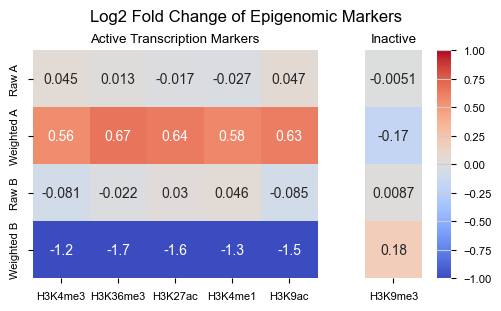

In [49]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata2, df1, df2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="Raw", name2="Weighted"
)
fig.suptitle("Log2 Fold Change of Epigenomic Markers")
out_name = os.path.join(out_dire, "chr2_wteig_log2.png")
fig.savefig(out_name, bbox_inches="tight", dpi=800)

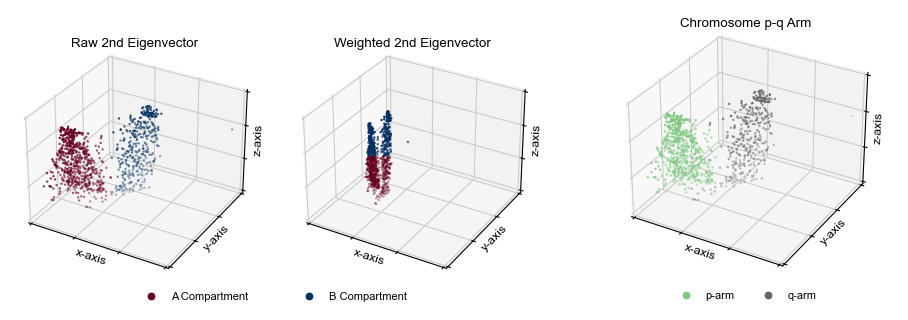

In [21]:
fig = plt.figure(figsize=(9, 3))
figs = fig.subfigures(1, 3, width_ratios=[2, 0.1, 1.1])
ax = figs[0].add_subplot(121, projection="3d")
s1 = ax.scatter(*df1.iloc[:,4:7].values.T, c=df1["cpmt"], s=3, linewidths=0, cmap="RdBu")
ax.set_title("Raw 2nd Eigenvector", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s1.legend_elements()[0][:1], ["A Compartment"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center right"
)

xlim, ylim = np.array(ax.get_xlim()), np.array(ax.get_ylim())
zlim = np.array(ax.get_zlim())

ax = figs[0].add_subplot(122, projection="3d")
ax.scatter(*df2.iloc[:,7:10].values.T, c=df2["cpmt"], s=3, linewidths=0, cmap="RdBu")
ax.set_title("Weighted 2nd Eigenvector", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
ratio = np.ptp(ax.get_zlim())/np.ptp(zlim)
ax.set(xlim=xlim*ratio, ylim=ylim*ratio)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s1.legend_elements()[0][1:], ["B Compartment"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center left"
)

ax = figs[2].add_subplot(projection="3d")
c = df1["e1"] < 91855520  # centromere position
s2 = ax.scatter(*df1.iloc[:,4:7].values.T, c=c, s=3, linewidths=0, cmap="Accent")
ax.set_title("Chromosome p-q Arm", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s2.legend_elements()[0], ["p-arm", "q-arm"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center"
)

fig.savefig(os.path.join(out_dire, "chr2_kmeans.pdf"), bbox_inches="tight")